In [3]:
import nasdaqdatalink as ndl
import pandas as pd
from ta import add_all_ta_features
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np


In [ ]:
#configurations
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
data_base = pd.read_csv('../data/data_normalized.csv', parse_dates=['date'])

NameError: name 'pd' is not defined

In [3]:
data_base.isna().sum()

vol_1y                     0
max_1y                     0
min_1y                     0
sma_1y                     0
sma_2y                     0
volatility_1y              0
revenue                    0
eps                        0
ebitda                     0
netinc                     0
roe                        0
evebitda                   0
fcfps                      0
pb                         0
pe                         0
marketcap                  0
ebit                       0
capex                      0
ncfo                       0
equity                     0
de                         0
revenue_yoy                0
ebitda_yoy               500
ebit_yoy                   0
eps_yoy                 1499
equity_yoy               499
capex_yoy               5438
pe_yoy                     0
pb_yoy                     0
fcfps_yoy                499
ncfo_yoy                 503
closeadj                   0
ret_6m                     0
ret_12m                    0
risk_free_rate

## XGBOOST CON TIME SERIES SPLIT DATA

In [7]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd


# Si no está ordenado:
data_base = data_base.sort_values('date')

features = [
    col for col in data_base.columns 
    if col not in ['ticker', 'date', 'cap_category', 'sharpe_1y', 'target_12m_final']
    and not col.startswith('target')
]

X = data_base[features].copy().replace([np.inf, -np.inf], np.nan)
y = data_base['target_12m_final'].copy().replace([np.inf, -np.inf], np.nan)
mask = X.notnull().all(axis=1) & y.notnull()
X = X.loc[mask]
y = y.loc[mask]


# Elige el número de splits, por ejemplo, 5 (ajusta según tu caso)
tscv = TimeSeriesSplit(n_splits=5)

mse_scores = []
r2_scores = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model = xgb.XGBRegressor(
        n_estimators=300, learning_rate=0.1, max_depth=6,
        subsample=0.7, colsample_bytree=0.7, random_state=42,
        early_stopping_rounds=15
    )
    
    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False)
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mse_scores.append(mse)
    r2_scores.append(r2)
    
    print(f"Fold {fold+1}: MSE={mse:.4f}, R2={r2:.4f}")

print(f"\nAverage MSE: {np.mean(mse_scores):.4f}")
print(f"Average R2: {np.mean(r2_scores):.4f}")


Fold 1: MSE=0.1152, R2=-0.1324
Fold 2: MSE=0.2357, R2=-0.1595
Fold 3: MSE=0.0609, R2=0.0134
Fold 4: MSE=0.1773, R2=0.1483
Fold 5: MSE=0.0832, R2=0.0393

Average MSE: 0.1344
Average R2: -0.0182


In [8]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
print("Top 10 features (último fold):")
for i in range(10):
    print(f"{X.columns[indices[i]]}: {importances[indices[i]]:.4f}")


Top 10 features (último fold):
risk_free_rate: 0.1022
ret_6m: 0.0998
vol_over_sma: 0.0459
dist_max_1y: 0.0398
volatility_1y: 0.0326
closeadj: 0.0325
ret_12m: 0.0268
ret_6m_vol: 0.0254
pb_yoy: 0.0250
log_marketcap: 0.0228


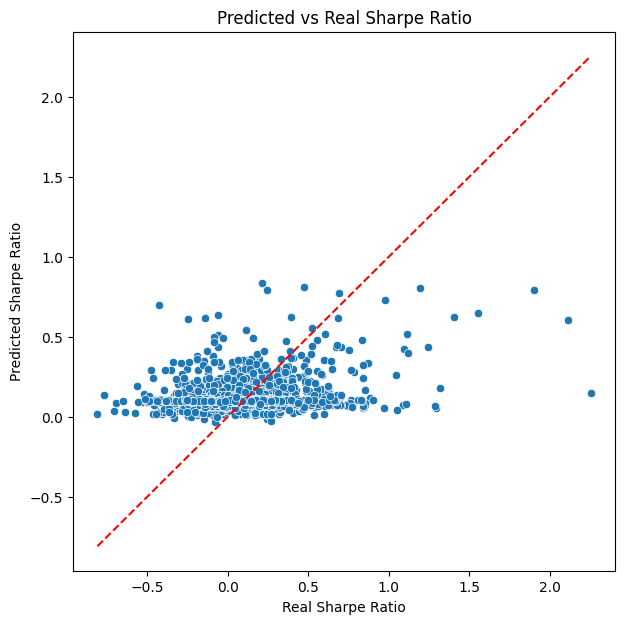

In [9]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Real Sharpe Ratio')
plt.ylabel('Predicted Sharpe Ratio')
plt.title('Predicted vs Real Sharpe Ratio')
plt.show()


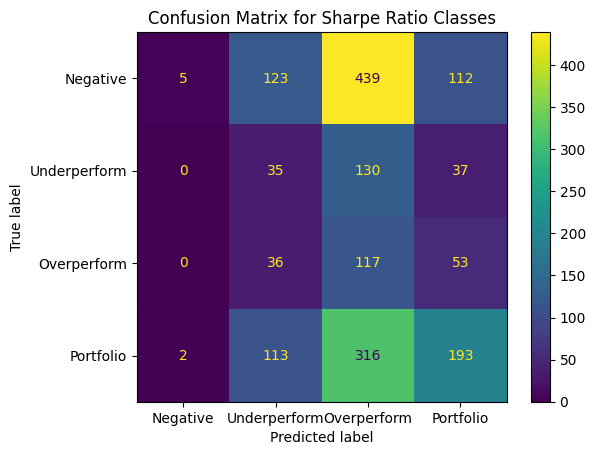

              precision    recall  f1-score   support

    Negative      0.714     0.007     0.015       679
 Overperform      0.117     0.568     0.194       206
   Portfolio      0.489     0.309     0.379       624
Underperform      0.114     0.173     0.138       202

    accuracy                          0.205      1711
   macro avg      0.358     0.264     0.181      1711
weighted avg      0.489     0.205     0.183      1711



In [10]:
def sharpe_class(sr):
    if sr < 0:
        return "Negative"
    elif sr < 0.07:
        return "Underperform"
    elif sr < 0.15:
        return "Overperform"
    else:
        return "Portfolio"

# Apply to test set predictions and real values
y_test_class = y_test.apply(sharpe_class)
y_pred_class = pd.Series(y_pred).apply(sharpe_class)

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_class, y_pred_class, labels=["Negative", "Underperform","Overperform", "Portfolio"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Underperform","Overperform", "Portfolio"])
disp.plot()
plt.title("Confusion Matrix for Sharpe Ratio Classes")
plt.show()

print(classification_report(y_test_class, y_pred_class, digits=3))


--------------------------------------------------------------------------------------------------------------------------------------

# Resumen del Código

Este código implementa un pipeline de machine learning para predecir retornos financieros a 12 meses (`target_12m_final`) utilizando un modelo XGBoost. Respeta las series temporales ordenando los datos por fecha y emplea `TimeSeriesSplit` con 5 folds para evitar fugas temporales, asegurando que los datos de entrenamiento sean anteriores a los de prueba. Las características se seleccionan excluyendo columnas como `ticker`, `date`, y variables objetivo, reemplazando valores infinitos por `NaN` y filtrando filas con datos faltantes.

El modelo se entrena con hiperparámetros específicos y early stopping basado en un conjunto de validación (el propio conjunto de prueba de cada fold). Predice retornos numéricos, que luego se clasifican en categorías ("Negative", "Underperform", "Perform", "Overperform") según umbrales definidos. Se crea un DataFrame de prueba por fold con predicciones y datos originales, y se evalúa un portafolio hipotético de activos clasificados como "Overperform", calculando el retorno promedio y el número de activos por fecha.

Los resultados se agrupan por año, calculando el retorno promedio del portafolio y el número de acciones sobre los folds, y se deriva un retorno acumulado. Finalmente, se genera un gráfico de retorno acumulado a lo largo del tiempo usando `matplotlib`. El código no testea explícitamente apariciones nuevas (e.g., empresas que entran al S&P 500), excluyendo filas con datos faltantes, y usa el conjunto de prueba de cada fold como validación out-of-sample.

         date  portfolio_return  n_stocks  cumulative_return
0  2004-03-31          0.134082     158.0           1.134082
1  2005-03-31          0.161509     428.0           1.317247
2  2006-03-31          0.122976     438.0           1.479236
3  2007-03-31         -0.073648     421.0           1.370293
4  2008-03-31         -0.263145     140.0           1.009708
5  2009-03-31          0.246846       3.0           1.258950
6  2010-03-31          0.195263     176.0           1.504776
7  2011-03-31          0.129912       9.0           1.700264
8  2012-03-31          0.209437      46.5           2.056363
9  2013-03-31          0.236133     402.0           2.541938
10 2014-03-31          0.134728     406.0           2.884408
11 2015-03-31         -0.007136     392.0           2.863824
12 2016-03-31          0.168896     177.0           3.347511
13 2017-03-31          0.137605     349.0           3.808146
14 2018-03-31          0.089709     307.0           4.149772
15 2019-03-31         -0

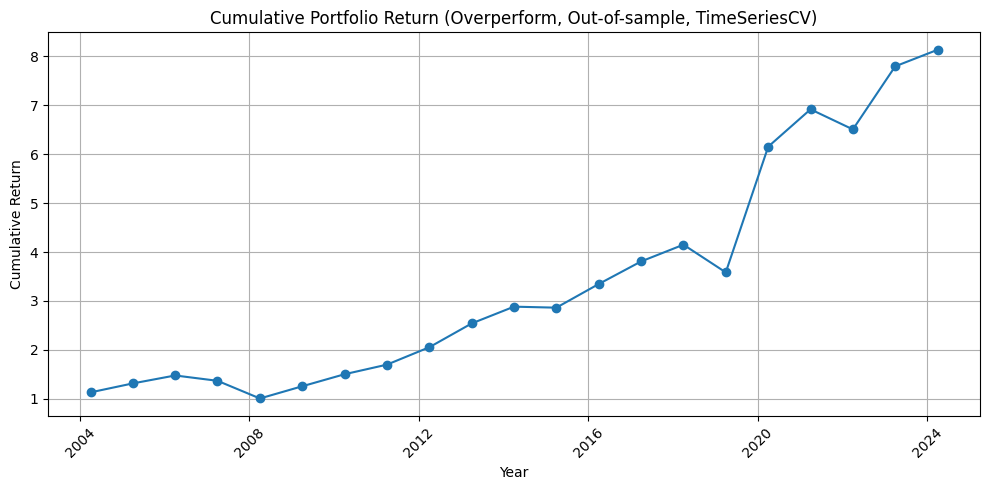

In [11]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd

# 0. Ordena por fecha para respetar la temporalidad
data_base = data_base.sort_values('date')

# 1. Define las features
features = [
    col for col in data_base.columns
    if col not in ['ticker', 'date', 'cap_category', 'sharpe_1y', 'target_12m_final']
    and not col.startswith('target')
]

X = data_base[features].replace([np.inf, -np.inf], np.nan)
y = data_base['target_12m_final'].replace([np.inf, -np.inf], np.nan)
mask = X.notnull().all(axis=1) & y.notnull()
X = X.loc[mask]
y = y.loc[mask]
data_filtered = data_base.loc[mask].copy()

# 2. Setup TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
result_list = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = xgb.XGBRegressor(
        n_estimators=300, learning_rate=0.07, max_depth=6,
        subsample=0.7, colsample_bytree=0.7, random_state=42,
        early_stopping_rounds=15
    )
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred = model.predict(X_test)

    # 3. Clasificación: puedes ajustar los cortes si lo deseas
    def return_class(sr):
        if sr < 0.0:
            return "Negative"
        elif sr < 0.05:
            return "Underperform"
        elif sr < 0.08:
            return "Perform"
        else:
            return "Overperform"

    y_pred_class = pd.Series(y_pred).apply(return_class).values

    # 4. DataFrame solo test (añade tickers/fechas originales)
    df_test = data_filtered.iloc[test_idx][['date', 'ticker', 'target_12m_final', 'sharpe_1y']].copy()
    df_test['predicted_return'] = y_pred
    df_test['predicted_class'] = y_pred_class
    df_test['fold'] = fold + 1

    # 5. Retorno del portfolio de Overperform en cada año
    for year, group in df_test.groupby('date'):
        overperf = group[group['predicted_class'] == 'Overperform']
        if len(overperf) > 0:
            portfolio_return = overperf['target_12m_final'].mean()
            n_stocks = len(overperf)
        else:
            portfolio_return = 0.0
            n_stocks = 0
        result_list.append({
            'date': year,
            'fold': fold + 1,
            'portfolio_return': portfolio_return,
            'n_stocks': n_stocks
        })

# 6. DataFrame de resultados
results = pd.DataFrame(result_list)
results = results.sort_values(['date', 'fold'])

# 7. Métrica ANUAL: promedio sobre los folds para cada año test
annual_results = results.groupby('date').agg({
    'portfolio_return': 'mean',
    'n_stocks': 'mean'
}).reset_index()

# 8. Retorno acumulado a lo largo de los años
annual_results['cumulative_return'] = (1 + annual_results['portfolio_return']).cumprod()

print(annual_results)

# 9. (Opcional) Gráfico de retorno acumulado
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(annual_results['date'], annual_results['cumulative_return'], marker='o')
plt.title("Cumulative Portfolio Return (Overperform, Out-of-sample, TimeSeriesCV)")
plt.xlabel("Year")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


In [9]:
results['date'].unique()

<DatetimeArray>
['2004-03-31 00:00:00', '2005-03-31 00:00:00', '2006-03-31 00:00:00',
 '2007-03-31 00:00:00', '2008-03-31 00:00:00', '2009-03-31 00:00:00',
 '2010-03-31 00:00:00', '2011-03-31 00:00:00', '2012-03-31 00:00:00',
 '2013-03-31 00:00:00', '2014-03-31 00:00:00', '2015-03-31 00:00:00',
 '2016-03-31 00:00:00', '2017-03-31 00:00:00', '2018-03-31 00:00:00',
 '2019-03-31 00:00:00', '2020-03-31 00:00:00', '2021-03-31 00:00:00',
 '2022-03-31 00:00:00', '2023-03-31 00:00:00', '2024-03-31 00:00:00']
Length: 21, dtype: datetime64[ns]

# Mismo código pero cambiando semilla 42--> 43

         date  portfolio_return  n_stocks  cumulative_return
0  2004-03-31          0.136301     158.0           1.136301
1  2005-03-31          0.163995     427.0           1.322649
2  2006-03-31          0.123205     437.0           1.485605
3  2007-03-31         -0.073648     421.0           1.376194
4  2008-03-31         -0.399962     139.0           0.825768
5  2009-03-31          0.966266      79.0           1.623679
6  2010-03-31          0.211589     136.0           1.967231
7  2011-03-31         -0.013189      15.0           1.941285
8  2012-03-31          0.146722      44.0           2.226115
9  2013-03-31          0.235708     388.0           2.750827
10 2014-03-31          0.128757     358.0           3.105016
11 2015-03-31         -0.001026     334.0           3.101829
12 2016-03-31          0.195820     167.0           3.709230
13 2017-03-31          0.151473     327.0           4.271079
14 2018-03-31          0.083550     286.0           4.627928
15 2019-03-31         -0

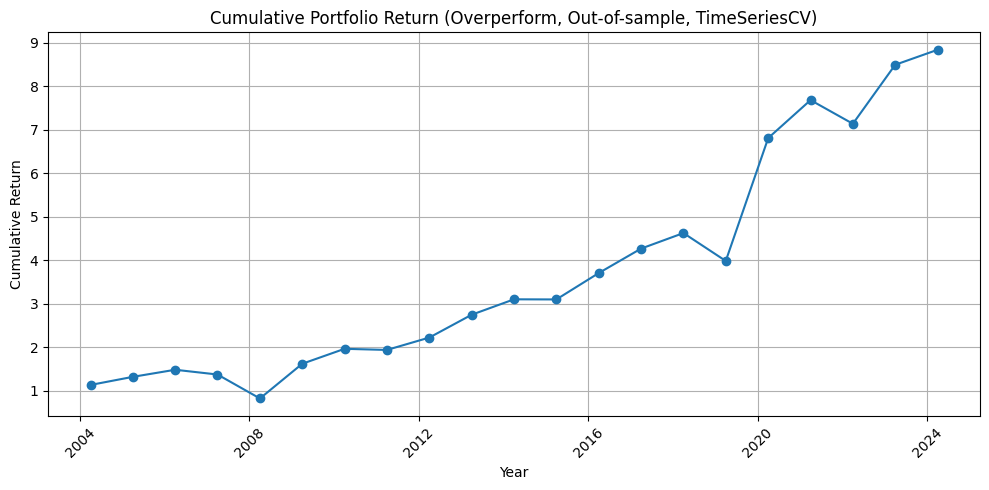

In [16]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


data_base = pd.read_csv('../data/data_base.csv', parse_dates=['date'])
# 0. Fijar semillas aleatorias para reproducibilidad
np.random.seed(43)  # Semilla para NumPy
# No es necesario random.seed() porque no usas el módulo random directamente

# 1. Ordena por fecha para respetar la temporalidad
data_base = data_base.sort_values('date')

# 2. Define las features
features = [
    col for col in data_base.columns
    if col not in ['ticker', 'date', 'cap_category', 'sharpe_1y', 'target_12m_final']
    and not col.startswith('target')
]

X = data_base[features].replace([np.inf, -np.inf], np.nan)
y = data_base['target_12m_final'].replace([np.inf, -np.inf], np.nan)
mask = X.notnull().all(axis=1) & y.notnull()
X = X.loc[mask]
y = y.loc[mask]
data_filtered = data_base.loc[mask].copy()

# 3. Setup TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
result_list = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = xgb.XGBRegressor(
        n_estimators=300, 
        learning_rate=0.07, 
        max_depth=6,
        subsample=0.7, 
        colsample_bytree=0.7, 
        random_state=43,  # Semilla para XGBoost
        early_stopping_rounds=15
    )
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred = model.predict(X_test)

    # 4. Clasificación: puedes ajustar los cortes si lo deseas
    def return_class(sr):
        if sr < 0.0:
            return "Negative"
        elif sr < 0.05:
            return "Underperform"
        elif sr < 0.08:
            return "Perform"
        else:
            return "Overperform"

    y_pred_class = pd.Series(y_pred).apply(return_class).values

    # 5. DataFrame solo test (añade tickers/fechas originales)
    df_test = data_filtered.iloc[test_idx][['date', 'ticker', 'target_12m_final', 'sharpe_1y']].copy()
    df_test['predicted_return'] = y_pred
    df_test['predicted_class'] = y_pred_class
    df_test['fold'] = fold + 1

    # 6. Retorno del portfolio de Overperform en cada año
    for year, group in df_test.groupby('date'):
        overperf = group[group['predicted_class'] == 'Overperform']
        if len(overperf) > 0:
            portfolio_return = overperf['target_12m_final'].mean()
            n_stocks = len(overperf)
        else:
            portfolio_return = 0.0
            n_stocks = 0
        result_list.append({
            'date': year,
            'fold': fold + 1,
            'portfolio_return': portfolio_return,
            'n_stocks': n_stocks
        })

# 7. DataFrame de resultados
results = pd.DataFrame(result_list)
results = results.sort_values(['date', 'fold'])

# 8. Métrica ANUAL: promedio sobre los folds para cada año test
annual_results = results.groupby('date').agg({
    'portfolio_return': 'mean',
    'n_stocks': 'mean'
}).reset_index()

# 9. Retorno acumulado a lo largo de los años
annual_results['cumulative_return'] = (1 + annual_results['portfolio_return']).cumprod()

print(annual_results)

# 10. Gráfico de retorno acumulado
plt.figure(figsize=(10,5))
plt.plot(annual_results['date'], annual_results['cumulative_return'], marker='o')
plt.title("Cumulative Portfolio Return (Overperform, Out-of-sample, TimeSeriesCV)")
plt.xlabel("Year")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

# Promediando semillas y alterando parámetros

Este código implementa un pipeline de machine learning para predecir retornos financieros a 12 meses (`target_12m_final`) usando XGBoost, respetando series temporales con `TimeSeriesSplit` (5 folds). Las características se seleccionan excluyendo columnas como `ticker`, `date`, y variables objetivo, manejando valores faltantes. Para reducir la variabilidad en los resultados debido a la aleatoriedad, se promedia sobre múltiples semillas (`seeds=[42, 43, 44, 45, 46]`). En cada fold, se entrena el modelo, se predicen retornos, se clasifican en categorías ("Negative", "Underperform", "Perform", "Overperform") con umbrales fijos, y se evalúa un portafolio de activos "Overperform". Los resultados se promedian por año y semilla, calculando el retorno acumulado y visualizando su evolución temporal.

         date  portfolio_return  n_stocks  cumulative_return
0  2004-03-31          0.131724     158.0           1.131724
1  2005-03-31          0.161089     427.8           1.314033
2  2006-03-31          0.122757     439.0           1.475340
3  2007-03-31         -0.073648     421.0           1.366685
4  2008-03-31         -0.279946     134.4           0.984087
5  2009-03-31          0.265252      16.6           1.245117
6  2010-03-31          0.198480     179.4           1.492249
7  2011-03-31          0.061185       4.8           1.583552
8  2012-03-31          0.126074      45.1           1.783197
9  2013-03-31          0.233556     431.8           2.199675
10 2014-03-31          0.128508     439.0           2.482350
11 2015-03-31         -0.008866     441.2           2.460342
12 2016-03-31          0.168784     202.9           2.875608
13 2017-03-31          0.142648     366.0           3.285807
14 2018-03-31          0.078700     318.0           3.544402
15 2019-03-31         -0

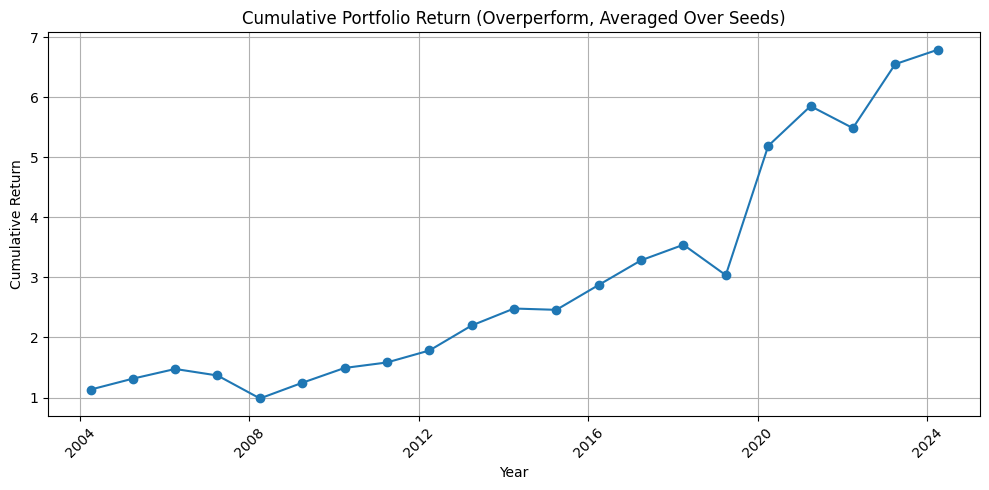

In [15]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0. Lista de semillas para promediar
seeds = [42, 43, 44, 45, 46]
all_results = []

for seed in seeds:
    # Fijar semillas para reproducibilidad dentro de cada iteración
    np.random.seed(seed)

    # 1. Ordena por fecha para respetar la temporalidad
    data_base = data_base.sort_values('date')

    # 2. Define las features
    features = [
        col for col in data_base.columns
        if col not in ['ticker', 'date', 'cap_category', 'sharpe_1y', 'target_12m_final']
        and not col.startswith('target')
    ]

    X = data_base[features].replace([np.inf, -np.inf], np.nan)
    y = data_base['target_12m_final'].replace([np.inf, -np.inf], np.nan)
    mask = X.notnull().all(axis=1) & y.notnull()
    X = X.loc[mask]
    y = y.loc[mask]
    data_filtered = data_base.loc[mask].copy()

    # 3. Setup TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    result_list = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = xgb.XGBRegressor(
            n_estimators=300, 
            learning_rate=0.07, 
            max_depth=4,  # Reducido para estabilidad
            subsample=0.9,  # Aumentado
            colsample_bytree=0.9,  # Aumentado
            random_state=seed,  # Semilla por iteración
            early_stopping_rounds=10
        )
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
        y_pred = model.predict(X_test)

        # 4. Clasificación
        def return_class(sr):
            if sr < 0.0:
                return "Negative"
            elif sr < 0.05:
                return "Underperform"
            elif sr < 0.08:
                return "Perform"
            else:
                return "Overperform"

        y_pred_class = pd.Series(y_pred).apply(return_class).values

        # 5. DataFrame solo test
        df_test = data_filtered.iloc[test_idx][['date', 'ticker', 'target_12m_final', 'sharpe_1y']].copy()
        df_test['predicted_return'] = y_pred
        df_test['predicted_class'] = y_pred_class
        df_test['fold'] = fold + 1

        # 6. Retorno del portfolio de Overperform
        for year, group in df_test.groupby('date'):
            overperf = group[group['predicted_class'] == 'Overperform']
            if len(overperf) > 0:
                portfolio_return = overperf['target_12m_final'].mean()
                n_stocks = len(overperf)
            else:
                portfolio_return = 0.0
                n_stocks = 0
            result_list.append({
                'date': year,
                'fold': fold + 1,
                'portfolio_return': portfolio_return,
                'n_stocks': n_stocks,
                'seed': seed
            })

    # 7. DataFrame de resultados por semilla
    results = pd.DataFrame(result_list)
    results = results.sort_values(['date', 'fold'])
    all_results.append(results)

# 8. Promediar resultados sobre todas las semillas
all_results_df = pd.concat(all_results)
annual_results = all_results_df.groupby(['date']).agg({
    'portfolio_return': 'mean',
    'n_stocks': 'mean'
}).reset_index()

# 9. Retorno acumulado
annual_results['cumulative_return'] = (1 + annual_results['portfolio_return']).cumprod()

print(annual_results)

# 10. Gráfico de retorno acumulado
plt.figure(figsize=(10,5))
plt.plot(annual_results['date'], annual_results['cumulative_return'], marker='o')
plt.title("Cumulative Portfolio Return (Overperform, Averaged Over Seeds)")
plt.xlabel("Year")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()